# Trajectories by simple integration for advected waves and unadvected waves

In [2]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

## Classes

In [3]:
@xs.process
class ProfileP:
    """Compute the evolution of positions and velocities."""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="a", intent="inout", description="positions of particules", attrs={"units": "m"})#attrs to print the units on graphs
    
    v_vars = xs.group("v_vars")
    v = xs.variable(dims="a", intent="inout", description="velocity of particules", attrs={"units": "m/s"})

    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        self._new_v = sum((u for u in self.v_vars))
       

    def finalize_step(self):
        
        self.v = self._new_v #v(t+dt)
        self.p += self._delta_p #p(t+dt)


In [4]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

@xs.process
class AdvectedWave:
    """Calculate velocity at t and in all positions.
"""
    
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")

    v_new = xs.variable(dims="a", intent="out", groups="v_vars")#v->a???
    
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start")#this way t is the beginning time of the simulation
    def initialize(self,t):
        self.v = analytical_velocity_advected(t, self.p, self.um, self.uw, self.w, self.k)
    
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args=["step_start","step_delta"])#then t=current step start(date)time (t+dt)
    def run_step(self,t,dt):
        self.v_new = analytical_velocity_advected(t+dt, self.p +self.v*dt, self.um, self.uw, self.w, self.k)  # v(x(t+dt),t+dt)


In [5]:
def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*x)


@xs.process
class UnadvectedWave:
    """Calculate velocity at t and in all positions.
"""
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")
    
    v_new = xs.variable(dims="a", intent="out", groups="v_vars")
    
    @xs.runtime(args="sim_start")
    def initialize(self,t):
        self.v = analytical_velocity_unadvected(t, self.p, self.um, self.uw, self.w, self.k)
        
    @xs.runtime(args=["step_start", "step_delta"])#then t=current step start (date)time
    def run_step(self,t,dt):
        self.v_new = analytical_velocity_unadvected(t+dt, self.p + self.v*dt, self.um, self.uw, self.w, self.k)


In [6]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="a", intent="out", groups="p_vars")
    v = xs.foreign(ProfileP, "v")
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt#self.v est la vitesse à l'instant t 

In [7]:
@xs.process
class InitRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N =xs.variable(description="number of particules", static=True)
    p = xs.foreign(ProfileP, "p", intent="out")
    a=xs.index(dims="a")
    
      
    def initialize(self):
        self.a = np.linspace(self.mini, self.maxi, self.N)
        self.p = self.a


## Model for advected waves integrated with the Euler method

In [8]:
# CREATE xs.Model
advect_model = xs.Model(
    {
        "profile": ProfileP,
        "init": InitRegular,
        "intmethod": Euler,
        "velocity": AdvectedWave
    }
)


In [9]:
advect_model

<xsimlab.Model (4 processes, 7 inputs)>
init
    mini        [in] minimum for initial position
    maxi        [in] maximum for initial position
    N           [in] number of particules
velocity
    um          [in] uniform and constant flow amplitude
    uw          [in] wave amplitude
    w           [in] wave pulsation
    k           [in] wave number
intmethod
profile

In [10]:
#CREATE SET UP
in_ds_advect = xs.create_setup(model=advect_model, 
                        clocks={'time': np.arange(0,86400*4, 3600),# hour by hour for four days
                                'otime': list(np.arange(0, 86400*4, 3600))}, 
                        master_clock='time',
                        input_vars={'init': {'mini': 0., 'maxi': 200000., 'N':100},#INITIALISATION
                                    'velocity': {'um': 0.1, 'uw': 0.1, 'w':1.454441043*10**(-4), 'k':6.2831*10**(-5)},
                                    },
                        output_vars={'profile__p' : 'otime','profile__v' : 'otime'})


In [11]:
in_ds_advect

<xarray.Dataset>
Dimensions:       (otime: 96, time: 96)
Coordinates:
  * time          (time) int64 0 3600 7200 10800 ... 331200 334800 338400 342000
  * otime         (otime) int64 0 3600 7200 10800 ... 334800 338400 342000
Data variables:
    init__mini    float64 0.0
    init__maxi    float64 2e+05
    init__N       int64 100
    velocity__um  float64 0.1
    velocity__uw  float64 0.1
    velocity__w   float64 0.0001454
    velocity__k   float64 6.283e-05

In [12]:
out_ds_advect = in_ds_advect.xsimlab.run(model=advect_model)
out_ds_advect

<xarray.Dataset>
Dimensions:       (a: 100, otime: 96, time: 96)
Coordinates:
  * a             (a) float64 3.459e+04 3.664e+04 ... 2.325e+05 2.346e+05
  * otime         (otime) int64 0 3600 7200 10800 ... 334800 338400 342000
  * time          (time) int64 0 3600 7200 10800 ... 331200 334800 338400 342000
Data variables:
    init__N       int64 100
    init__maxi    float64 2e+05
    init__mini    float64 0.0
    profile__p    (otime, a) float64 0.0 2.02e+03 ... 2.325e+05 2.346e+05
    profile__v    (otime, a) float64 0.2 0.1992 0.1968 ... 0.1958 0.1913 0.1854
    velocity__k   float64 6.283e-05
    velocity__um  float64 0.1
    velocity__uw  float64 0.1
    velocity__w   float64 0.0001454

### Positions plots

In [19]:
i=0
j=96
step=6


_p = out_ds_advect.profile__p
_v = out_ds_advect.profile__v
#_p.isel(otime=[95])
_v.isel(otime=[94])
#_p.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", marker=".", markersize=1, figsize=(22,3));

<xarray.DataArray 'profile__v' (otime: 1, a: 100)>
array([[1.48816211e-01, 1.36963249e-01, 1.24426587e-01, 1.11426256e-01,
        9.81956243e-02, 8.49759666e-02, 7.20105523e-02, 5.95384992e-02,
        4.77886850e-02, 3.69740034e-02, 2.72862304e-02, 1.88917218e-02,
        1.19280999e-02, 6.50201428e-03, 2.68799062e-03, 5.28311872e-04,
        3.38231097e-05, 1.18551235e-03, 3.93669788e-03, 8.21564751e-03,
        1.39284630e-02, 2.09620817e-02, 2.91872711e-02, 3.84615216e-02,
        4.86317683e-02, 5.95369018e-02, 7.10100484e-02, 8.28806211e-02,
        9.49761568e-02, 1.07123969e-01, 1.19152647e-01, 1.30893451e-01,
        1.42181632e-01, 1.52857737e-01, 1.62768919e-01, 1.71770312e-01,
        1.79726482e-01, 1.86512998e-01, 1.92018112e-01, 1.96144578e-01,
        1.98811575e-01, 1.99956714e-01, 1.99538085e-01, 1.97536255e-01,
        1.93956153e-01, 1.88828702e-01, 1.82212094e-01, 1.74192556e-01,
        1.64884474e-01, 1.54429746e-01, 1.42996261e-01, 1.30775432e-01,
        1.17978790e-01, 1.04833665e-01, 9.15780859e-02, 7.84550850e-02,
        6.57066298e-02, 5.35674709e-02, 4.22591906e-02, 3.19847322e-02,
        2.29236575e-02, 1.52283232e-02, 9.02109725e-03, 4.39266644e-03,
        1.40141077e-03, 7.37624854e-05, 4.05418615e-04, 2.36324645e-03,
        5.88770817e-03, 1.08956324e-02, 1.72831742e-02, 2.49288269e-02,
        3.36963764e-02, 4.34377146e-02, 5.39954602e-02, 6.52053552e-02,
        7.68984290e-02, 8.89029406e-02, 1.01046119e-01, 1.13155735e-01,
        1.25061543e-01, 1.36596633e-01, 1.47598738e-01, 1.57911536e-01,
        1.67385989e-01, 1.75881753e-01, 1.83268685e-01, 1.89428468e-01,
        1.94256360e-01, 1.97663071e-01, 1.99576729e-01, 1.99944915e-01,
        1.98736699e-01, 1.95944589e-01, 1.91586308e-01, 1.85706264e-01,
        1.78376591e-01, 1.69697605e-01, 1.59797564e-01, 1.48831590e-01]])
Coordinates:
  * a        (a) float64 3.459e+04 3.664e+04 3.869e+04 ... 2.325e+05 2.346e+05
  * otime    (otime) int64 338400
Attributes:
    description:  velocity of particules
    units:        m/s

Trajectories

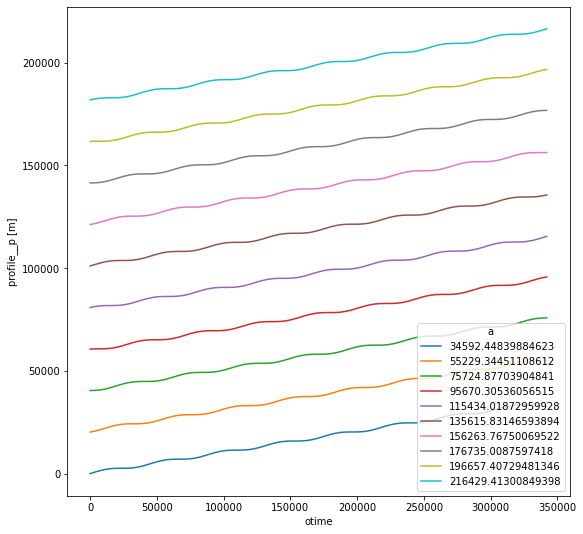

In [14]:
_p.isel(a=slice(0,None,10)).plot(x="otime", hue="a", figsize=(9,9));
#_p.isel(a=np.arange(0,50,4)).plot(x="otime", hue="a", figsize=(9,9));

#### Advancement Comment assigner l'unité??

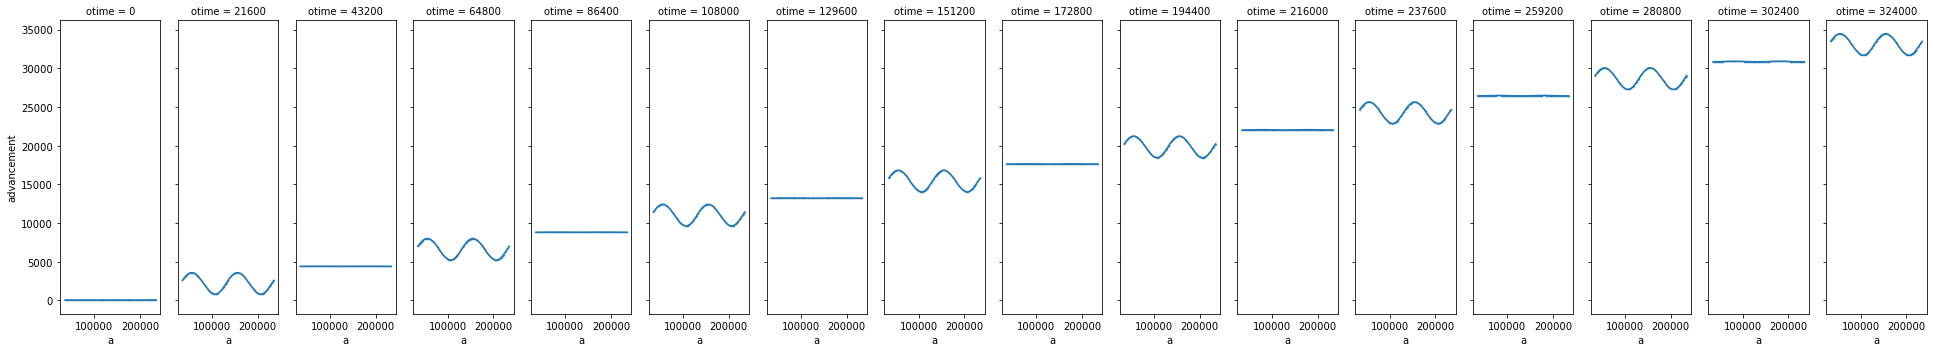

In [15]:
_p0 = _p.isel(otime=0, drop=True)
out_ds_advect['advancement'] = _p-_p0
adv=out_ds_advect.advancement
adv.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", marker=".", markersize=1, figsize=(27,5));

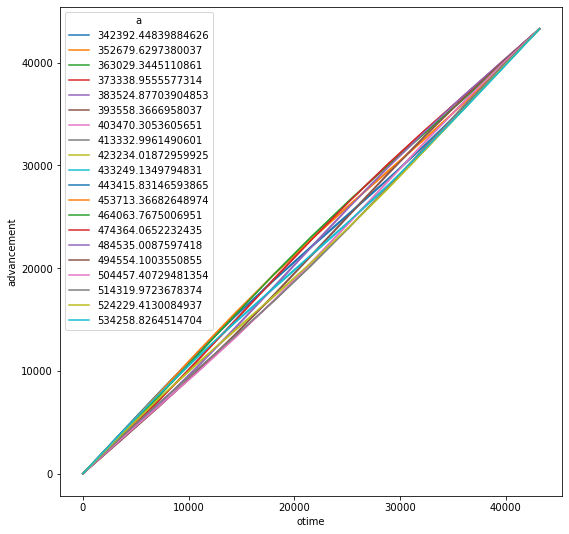

In [32]:
adv.isel(a=slice(0,None,5)).isel(otime=np.arange(0,13)).plot(x="otime", hue="a", figsize=(9,9))



### Velocities plots

In [33]:
_ds=out_ds_advect
v_a = analytical_velocity_advected(_ds.otime, _ds.profile__p, _ds.velocity__um, _ds.velocity__uw, _ds.velocity__w, _ds.velocity__k)

In [34]:
v_a.coords

Coordinates:
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000
  * a        (a) float64 3.424e+05 3.444e+05 3.465e+05 ... 5.403e+05 5.424e+05

In [35]:
#_ds=_ds.assign_coords(v=np.arange(0,100)).rename({"v":"p"})

In [36]:
(v_a-_ds.profile__v)

<xarray.DataArray (otime: 96, a: 100)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000
  * a        (a) float64 3.424e+05 3.444e+05 3.465e+05 ... 5.403e+05 5.424e+05

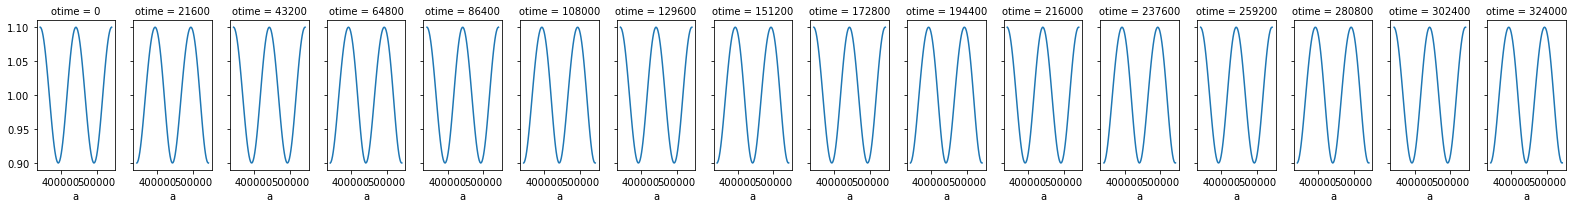

In [134]:
v_a.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", figsize=(22,3));

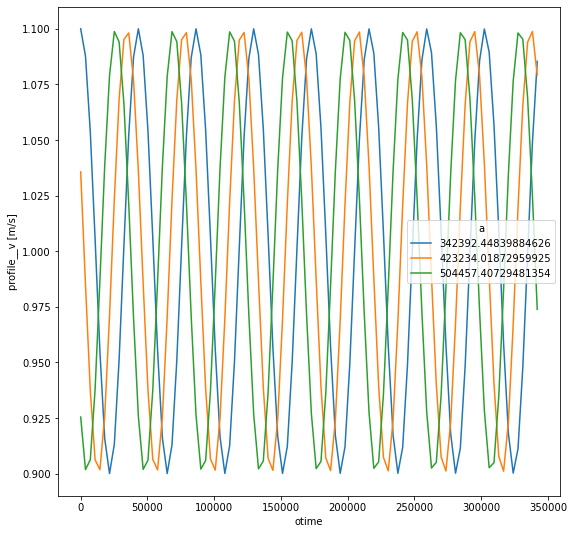

In [135]:
_v.isel(a=slice(0,None,40)).plot(x="otime", hue="a", figsize=(9,9));

## Model for unadvected waves integrated with Euler
### Positions plots

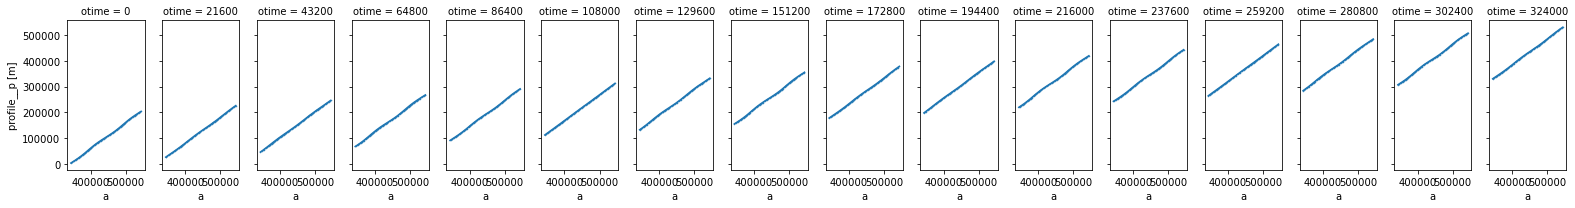

In [62]:
unadvect_model = advect_model.update_processes({"velocity": UnadvectedWave})
out_ds_unadvect = in_ds_advect.xsimlab.run(model=unadvect_model)
_up = out_ds_unadvect.profile__p
_uv = out_ds_unadvect.profile__v
_up.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", marker=".", markersize=1, figsize=(22,3));

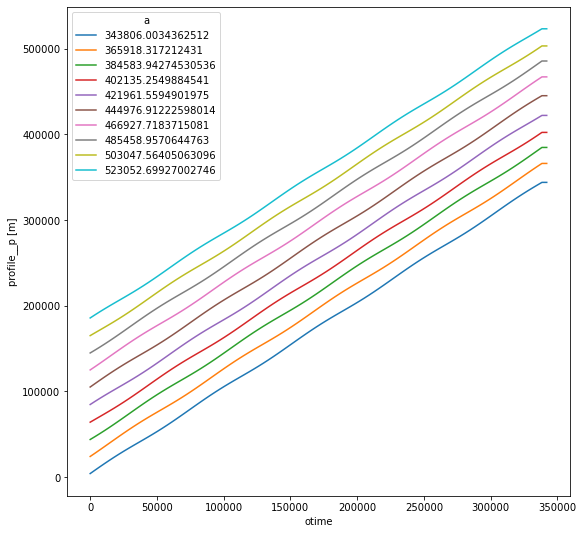

In [63]:
_up.isel(a=slice(0,None,10)).plot(x="otime", hue="a", figsize=(9,9));

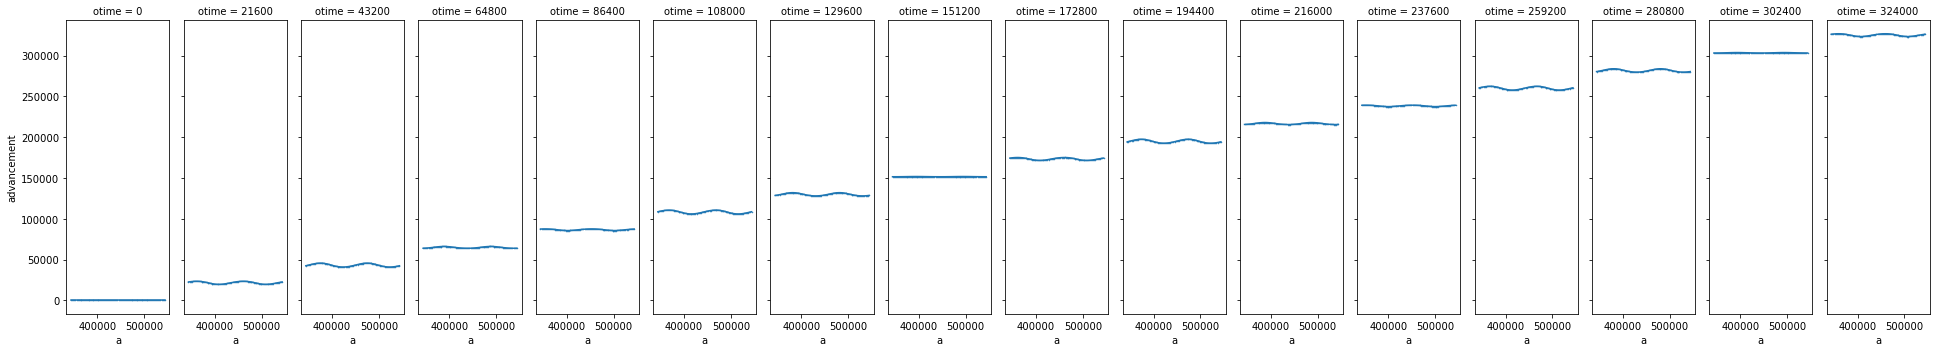

In [64]:
_up0 = _up.isel(otime=0, drop=True)
out_ds_unadvect['advancement'] = _up-_up0
uadv=out_ds_unadvect.advancement
uadv.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", marker=".", markersize=1, figsize=(27,5));

### Velocities plots

In [42]:
_uds = out_ds_unadvect
uv_a = analytical_velocity_unadvected(_uds.otime, _uds.profile__p, _uds.velocity__um, _uds.velocity__uw, _uds.velocity__w, _uds.velocity__k)

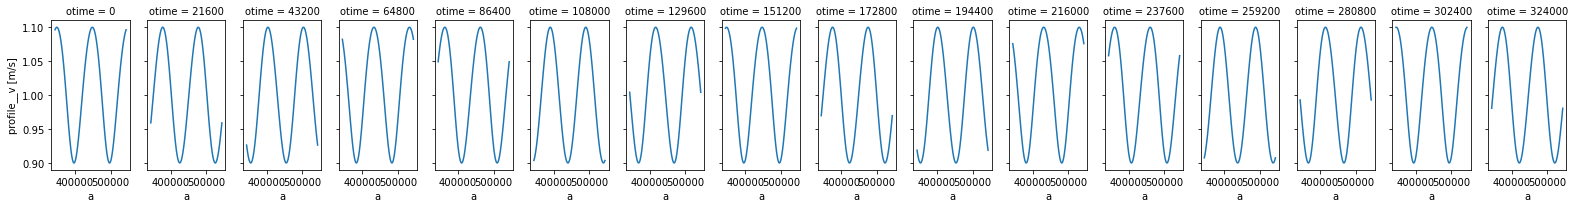

In [43]:
_uv.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", figsize=(22,3));

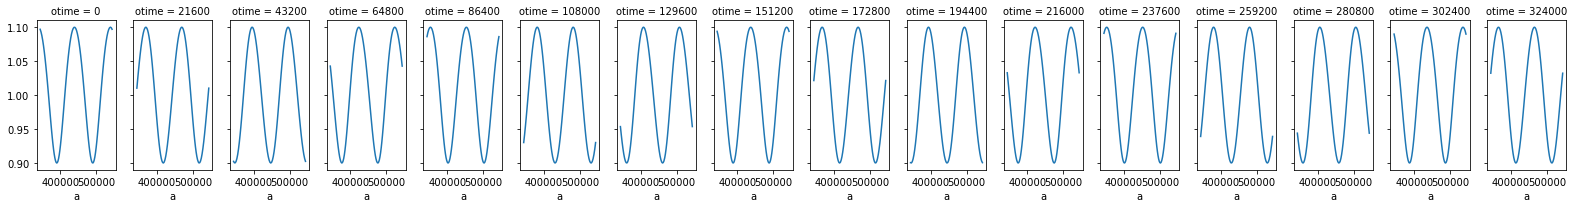

In [44]:
uv_a.isel(otime=np.arange(i,j,step), drop=True).plot(col="otime", figsize=(22,3));

In [45]:
(uv_a-_uds.profile__v)

<xarray.DataArray (otime: 96, a: 100)>
array([[ 0.00067232, -0.00587599, -0.01231189, ...,  0.01369464,
         0.00723728,  0.00068115],
       [ 0.01473377,  0.00831205,  0.00179296, ...,  0.02686335,
         0.02095895,  0.01474229],
       [ 0.02779181,  0.02195721,  0.01581165, ...,  0.03810729,
         0.03321494,  0.02779939],
       ...,
       [ 0.03388565,  0.0391946 ,  0.04363791, ...,  0.0211079 ,
         0.02780688,  0.03387798],
       [ 0.0199633 ,  0.02674121,  0.0329008 , ...,  0.00518168,
         0.0127122 ,  0.01995385],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * otime    (otime) int64 0 3600 7200 10800 ... 331200 334800 338400 342000
  * a        (a) float64 3.438e+05 3.461e+05 3.485e+05 ... 5.415e+05 5.438e+05

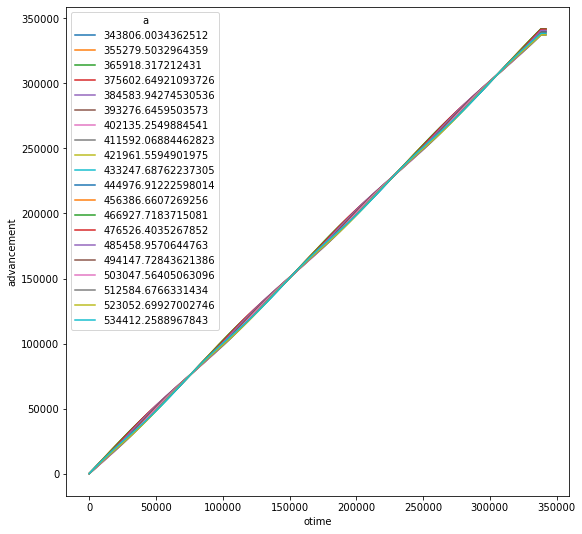

In [46]:
uadv.isel(a=slice(0,None,5)).isel(otime=np.arange(0,96)).plot(x="otime", hue="a", figsize=(9,9)) #ajouter droite um*t???